# Piano Audio To Partitures

### Imports

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
from scipy.io.wavfile import write
from sklearn.cluster import KMeans
from scipy.signal import convolve2d
from pathlib import Path
import os

AudioSegment.converter = os.getcwd()+ "\\ffmpeg.exe"    
AudioSegment.ffmpeg = os.getcwd()+ "\\ffmpeg.exe"            
AudioSegment.ffprobe   = os.getcwd()+ "\\ffprobe.exe"

### Functions

In [3]:
def round_note_values(note_values):
    note_values[note_values > 5] = 6.0 # dotted whole notes
    note_values[(note_values >= 3.5) & (note_values <= 5)] = 4.0 # whole notes
    note_values[(note_values > 2.5) & (note_values < 3.5)] = 3.0 # dotted half notes
    note_values[(note_values >= 1.75) & (note_values <= 2.5)] = 2.0 # half notes
    note_values[(note_values > 1.25) & (note_values < 1.75)] = 1.5 # dotted quarter notes
    note_values[(note_values >= 0.875) & (note_values <= 1.25)] = 1.0 # quarter notes
    note_values[(note_values > 0.625) & (note_values < 0.875)] = 0.75 # dotted eighth notes
    note_values[(note_values >= 0.4375) & (note_values <= 0.625)] = 0.5 # eighth notes
    note_values[(note_values > 0.3125) & (note_values < 0.4375)] = 0.375 # dotted sixteenth notes
    note_values[(note_values >= 0.1875) & (note_values <= 0.3125)] = 0.25 # sixteenth notes
    note_values[(note_values >= 0.09375) & (note_values < 0.1875)] = 0.125 # thirty-second notes
    note_values[note_values < 0.09375] = 0.0625 # sixty-fourth notes
    return note_values

### Trimming and cleaning song

In [4]:

file_name = "OdeToJoy"
trimmed_name = file_name + "_Trimmed.mp3"

audio = AudioSegment.from_file(file_name + ".mp3", format="mp3")
# Trimming first 6 seconds
trimmed_audio = audio[6000:]
trimmed_audio.export(trimmed_name, format="mp3")

<_io.BufferedRandom name='OdeToJoy_Trimmed.mp3'>

In [5]:
y, sr = librosa.load(trimmed_name)

In [6]:
file_name2 = "SistersOfBattle"
trimmed_name2 = file_name2 + "_Trimmed.mp3"

audio = AudioSegment.from_file(file_name2 + ".mp3", format="mp3")
# Trimming first 6 seconds
trimmed_audio = audio[3000:]
trimmed_audio.export(trimmed_name2, format="mp3")

<_io.BufferedRandom name='SistersOfBattle_Trimmed.mp3'>

In [7]:
y2, sr2 = librosa.load(trimmed_name2)

### Number of beats

[0.60371882 0.58049887 0.60371882 0.60371882 0.60371882 0.60371882
 0.60371882 0.60371882 0.58049887 0.60371882 0.90557823 0.30185941
 1.18421769 0.60371882 0.60371882 0.60371882 0.60371882 0.60371882
 0.60371882 0.60371882 0.58049887 0.60371882 0.60371882 0.60371882
 0.60371882 0.88235828 0.30185941 1.20743764 0.60371882 0.60371882
 0.60371882 0.58049887 0.60371882 0.30185941 0.30185941 0.60371882
 0.60371882 0.60371882 0.30185941 0.30185941 0.58049887 0.60371882
 0.60371882 0.60371882 1.18421769 0.60371882 0.60371882 0.60371882
 0.60371882 0.60371882 0.60371882 0.58049887 0.60371882 0.60371882
 0.60371882 0.60371882 0.58049887 0.90557823 0.30185941]


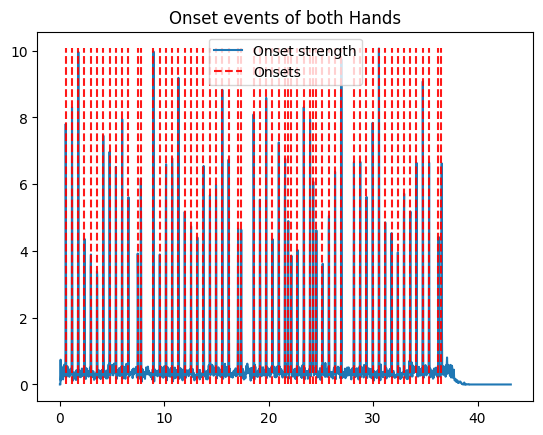

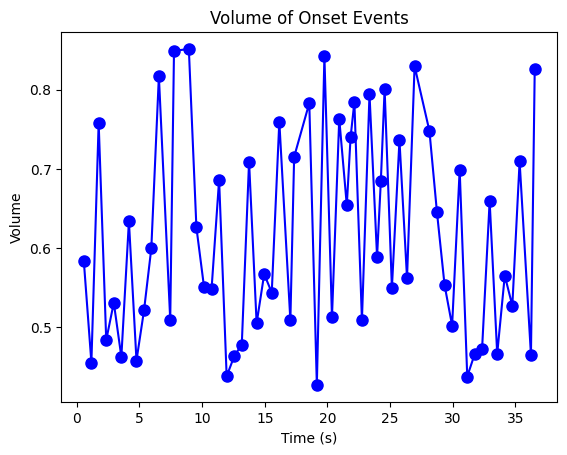

In [8]:
# Detect where there are significant changes in the audio signal (Onsets)
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Calculate time differences between consecutive onsets
onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
onset_times = librosa.frames_to_time(onsets, sr=sr)
deltas = np.diff(onset_times)
print(deltas)

#Plot Onset events
D = np.abs(librosa.stft(y))
times = librosa.times_like(D, sr=sr)


plt.plot(times, onset_env, label='Onset strength')
plt.vlines(times[onsets], 0, onset_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
plt.legend()
plt.title("Onset events of both Hands")
plt.show()


D = np.abs(librosa.stft(y))

# Calculate the volume of each onset event
onset_volumes = [np.mean(D[:, onset]) for onset in onsets]

# Plot the onset volumes
plt.plot(onset_times, onset_volumes, 'bo-', markersize=8)  # Plotting volumes against onset times
plt.xlabel('Time (s)')
plt.ylabel('Volume')
plt.title('Volume of Onset Events')
plt.show()



In [9]:
#Get louder beat from first ten notes (Excluding the first note)
first_ten = np.array(onset_volumes[1:10])
max_beat = first_ten.argmax() + 1
print(max_beat)

# Get bpm to calculate quarter note time value
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
valorNegra = np.mean(np.diff(beat_times))
print("Valor Negra: ", valorNegra)
#Divide note time values by quarter note to get number of beats per note (0.5, 1, 2, 4)
valorNotes = deltas/valorNegra

print("ABANS///////////////////////////////////////////")
print(valorNotes)
#Apply thresholds to valorNotes to get exact values
valorNotes = round_note_values(valorNotes)

print("DESPRES///////////////////////////////////////////")
print(valorNotes)


2
Valor Negra:  0.600235827664399
ABANS///////////////////////////////////////////
[1.00580271 0.96711799 1.00580271 1.00580271 1.00580271 1.00580271
 1.00580271 1.00580271 0.96711799 1.00580271 1.50870406 0.50290135
 1.9729207  1.00580271 1.00580271 1.00580271 1.00580271 1.00580271
 1.00580271 1.00580271 0.96711799 1.00580271 1.00580271 1.00580271
 1.00580271 1.47001934 0.50290135 2.01160542 1.00580271 1.00580271
 1.00580271 0.96711799 1.00580271 0.50290135 0.50290135 1.00580271
 1.00580271 1.00580271 0.50290135 0.50290135 0.96711799 1.00580271
 1.00580271 1.00580271 1.9729207  1.00580271 1.00580271 1.00580271
 1.00580271 1.00580271 1.00580271 0.96711799 1.00580271 1.00580271
 1.00580271 1.00580271 0.96711799 1.50870406 0.50290135]
DESPRES///////////////////////////////////////////
[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.5 0.5 2.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.5 0.5 2.  1.  1.  1.  1.  1.  0.5 0.5 1.
 1.  1.  0.5 0.5 1.  1.  1.  1.  2.  1.  1.  1.  1.  1.  1.  1

In [10]:
#Sum values of first note and loudest note
beats_per_measure = np.sum(valorNotes[:max_beat])
print(beats_per_measure)

2.0


# POTSER MIRAR SI ES MULTIPLE DE 4 O DE 3, I DESPRES MIRAR LA LLARGADA DE LES NOTES DE LA MA ESQUERRA

In [11]:
if(beats_per_measure % 4 == 0):
    measure = [4, 4]
else:
    if(beats_per_measure % 3 == 0):
        measure = [3, 4]
    else:
        if((beats_per_measure*2) % 2 == 0):
            measure = [2, 4]
        else:
            if((beats_per_measure*2) % 3 == 0):
                measure = [3, 8]
            else:
                measure = [4, 4]

print(measure)

[4, 8]


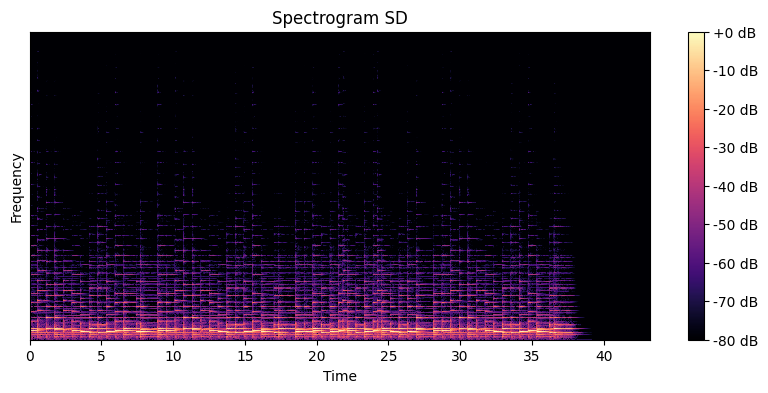

(1025, 4613)


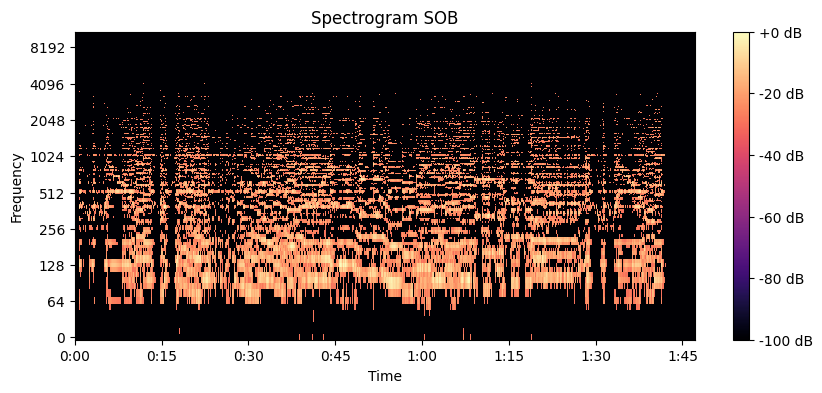

In [12]:
D = librosa.stft(y)

S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)




left_hand_freq_range = (0, 700)  # Example frequency range for left hand (in Hz)
right_hand_freq_range = (700, 5000)  # Example frequency range for right hand (in Hz)

left_hand_bin_range = (int(left_hand_freq_range[0] * D.shape[0] / sr),
                       int(left_hand_freq_range[1] * D.shape[0] / sr))

right_hand_bin_range = (int(right_hand_freq_range[0] * D.shape[0] / sr),
                        int(right_hand_freq_range[1] * D.shape[0] / sr))

# Create masks to isolate frequency components for each hand
left_hand_mask = np.zeros_like(D, dtype=bool)
left_hand_mask[left_hand_bin_range[0]:left_hand_bin_range[1], :] = True

right_hand_mask = np.zeros_like(D, dtype=bool)
right_hand_mask[right_hand_bin_range[0]:right_hand_bin_range[1], :] = True

# Apply masks to the STFT
left_hand_stft = D * left_hand_mask
right_hand_stft = D * right_hand_mask

# Invert the STFT to obtain separated audio signals for each hand
left_hand_audio = librosa.istft(left_hand_stft)
right_hand_audio = librosa.istft(right_hand_stft)

left_hand_audio_scaled = (left_hand_audio * 32767).astype(np.int16)
right_hand_audio_scaled = (right_hand_audio * 32767).astype(np.int16)

# Save the separated audio signals to WAV files
write('left_hand_audio.wav', sr, left_hand_audio_scaled)
write('right_hand_audio.wav', sr, right_hand_audio_scaled)


'''
# Convert amplitude spectrogram to dB scale
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
#Apply threshold to take noise out
S_db[S_db < -30] = -100
print(S_db.shape)

#Calculate mean of indices where there is sound
indices = np.argwhere(S_db != -100)
meanIndex = np.mean(indices[ :, 0])
print(meanIndex)


# Calculate Short-Time Fourier Transform (STFT)
D = np.abs(librosa.stft(y))


num_bins = S_db.shape[0]  # Number of frequency bins in the spectrogram
start = 0
end = 8192
# Create the exponential array
exponential_array = np.flip(8192 - np.geomspace(0.001, 8192.0, num=1024))
plt.plot(exponential_array)
#print(exponential_array[round(meanIndex)])
print(exponential_array[round(meanIndex)])
print(exponential_array.shape)
print(exponential_array)
'''





# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram SD')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


D2 = librosa.stft(y2)

# Convert amplitude spectrogram to dB scale
S_db2 = librosa.amplitude_to_db(np.abs(D2), ref=np.max)
S_db2[S_db2 < -30] = -100
print(S_db2.shape)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db2, sr=sr2, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram SOB')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


In [13]:
y_l, sr_l = librosa.load('left_hand_audio.wav')
y_r, sr_r = librosa.load('right_hand_audio.wav')

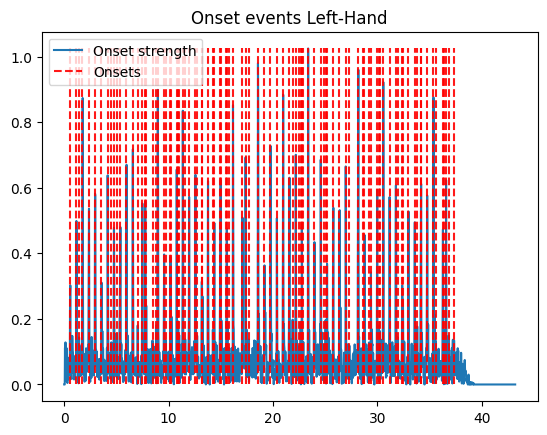

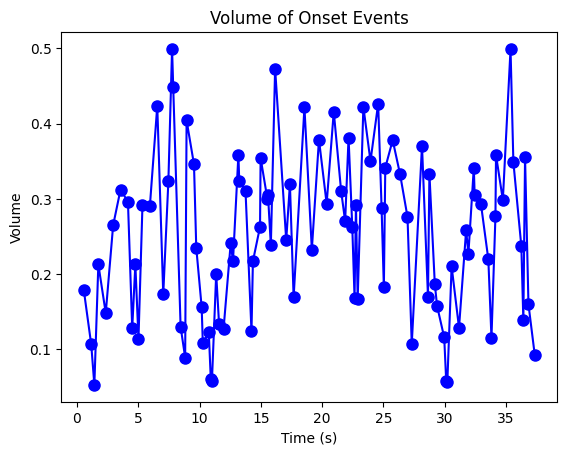

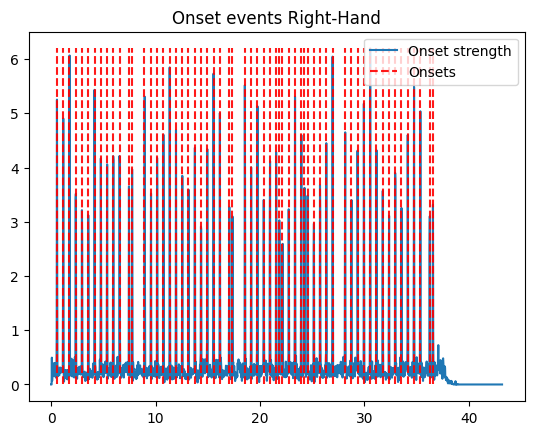

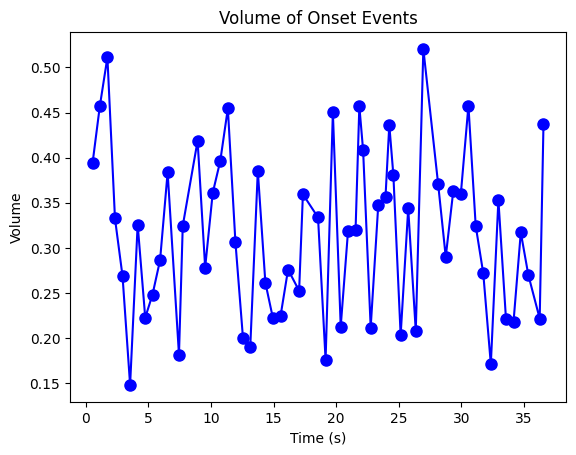

In [14]:
# Detect where there are significant changes in the audio signal (Onsets)
onset_env_l = librosa.onset.onset_strength(y=y_l, sr=sr_l)

# Calculate time differences between consecutive onsets
onsets_l = librosa.onset.onset_detect(onset_envelope=onset_env_l, sr=sr_l)
onset_times_l = librosa.frames_to_time(onsets_l, sr=sr_l)
deltas_l = np.diff(onset_times_l)
#print(deltas)

#Plot Onset events
D_l = np.abs(librosa.stft(y_l))
times_l = librosa.times_like(D_l, sr=sr_l)


plt.plot(times_l, onset_env_l, label='Onset strength')
plt.vlines(times_l[onsets_l], 0, onset_env_l.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
plt.legend()
plt.title("Onset events Left-Hand")
plt.show()


D_l = np.abs(librosa.stft(y_l))

# Calculate the volume of each onset event
onset_volumes_l = [np.mean(D_l[:, onset]) for onset in onsets_l]

# Plot the onset volumes
plt.plot(onset_times_l, onset_volumes_l, 'bo-', markersize=8)  # Plotting volumes against onset times
plt.xlabel('Time (s)')
plt.ylabel('Volume')
plt.title('Volume of Onset Events')
plt.show()


# Detect where there are significant changes in the audio signal (Onsets)
onset_env_r = librosa.onset.onset_strength(y=y_r, sr=sr_r)

#onset_env_l[onset_env_l < 2] = 0

# Calculate time differences between consecutive onsets
onsets_r = librosa.onset.onset_detect(onset_envelope=onset_env_r, sr=sr_r)
onset_times_r = librosa.frames_to_time(onsets_r, sr=sr_r)
deltas_r = np.diff(onset_times_r)
#print(deltas)

#Plot Onset events
D_r = np.abs(librosa.stft(y_r))
times_r = librosa.times_like(D_r, sr=sr_r)

plt.plot(times_r, onset_env_r, label='Onset strength')
plt.vlines(times_r[onsets_r], 0, onset_env_r.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
plt.legend()
plt.title("Onset events Right-Hand")
plt.show()


D_r = np.abs(librosa.stft(y_r))

# Calculate the volume of each onset event
onset_volumes_r = [np.mean(D_r[:, onset]) for onset in onsets_r]

# Plot the onset volumes
plt.plot(onset_times_r, onset_volumes_r, 'bo-', markersize=8)  # Plotting volumes against onset times
plt.xlabel('Time (s)')
plt.ylabel('Volume')
plt.title('Volume of Onset Events')
plt.show()

In [15]:
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print(tempo)

[99.38401442]


In [16]:
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
beat_times

array([ 0.55727891,  1.16099773,  1.76471655,  2.36843537,  2.9721542 ,
        3.57587302,  4.15637188,  4.7600907 ,  5.36380952,  5.96752834,
        6.57124717,  7.17496599,  7.77868481,  8.38240363,  8.96290249,
        9.56662132, 10.17034014, 10.77405896, 11.35455782, 11.95827664,
       12.56199546, 13.16571429, 13.76943311, 14.37315193, 14.97687075,
       15.55736961, 16.16108844, 16.76480726, 17.36852608, 17.9722449 ,
       18.55274376, 19.15646259, 19.76018141, 20.36390023, 20.96761905,
       21.57133787, 22.17505669, 22.77877551, 23.35927438, 23.9629932 ,
       24.56671202, 25.17043084, 25.77414966, 26.37786848, 26.95836735,
       27.56208617, 28.16580499, 28.76952381, 29.37324263, 29.9537415 ,
       30.55746032, 31.16117914, 31.76489796, 32.36861678, 32.9723356 ,
       33.57605442, 34.15655329, 34.76027211, 35.36399093, 35.96770975,
       36.57142857])

In [17]:
valorNegra = np.mean(np.diff(beat_times))
print(deltas/valorNegra)

[1.00580271 0.96711799 1.00580271 1.00580271 1.00580271 1.00580271
 1.00580271 1.00580271 0.96711799 1.00580271 1.50870406 0.50290135
 1.9729207  1.00580271 1.00580271 1.00580271 1.00580271 1.00580271
 1.00580271 1.00580271 0.96711799 1.00580271 1.00580271 1.00580271
 1.00580271 1.47001934 0.50290135 2.01160542 1.00580271 1.00580271
 1.00580271 0.96711799 1.00580271 0.50290135 0.50290135 1.00580271
 1.00580271 1.00580271 0.50290135 0.50290135 0.96711799 1.00580271
 1.00580271 1.00580271 1.9729207  1.00580271 1.00580271 1.00580271
 1.00580271 1.00580271 1.00580271 0.96711799 1.00580271 1.00580271
 1.00580271 1.00580271 0.96711799 1.50870406 0.50290135]


# ARREGLAR EL QUE NO AGAFA LA ULTIMA NOTA JA QUE CALCULO LA DIFERENCIA ENTRE CADA BEAT I PER TANT NO CALCULO LA DIFERENCIA ENTRE LA ULTIMA NOTA I EL FINAL